In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 1.0.0
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# 全体的な設定
device = torch.device('cuda' if use_gpu else 'cpu')

batchsize = 64

# シード値の指定（cuDNNによるランダム性などはまだ残っているので、厳密ではない）
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)

In [3]:
root_dir = '../../data/'

# 訓練画像が入っているディレクトリ
image_dir = root_dir + 'kkanji2_curated/'

# ログと重みを保存するためのディレクトリ
log_dir = root_dir + 'kkanji2_curated_log/'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

# ラベルのためのjsonを読み込む
# このjsonファイルは"json_preprocessing.ipynb"で　漢字 ->　部首のリスト のjsonから utf16の下４桁 -> 部首のリストのjsonに前処理済
with open(root_dir + 'kanjivg_radical/utf16_to_radical.json') as f:
    utf16_to_radical = json.load(f)

In [4]:
# 今は数が少ないので直書きしてあるが、より複雑な条件で部首を選ぶならここに書くことを想定
def select_radical():
    return ['⻖', '亻', '氵', '糸', '彳', '石', '扌',
            '可', '合', '工', '皮', '少', '立']

radical_list = select_radical()
n_radical = len(radical_list)

# one-hotに変換するための前準備としてradical -> indexのdictを作っておく
radical_dict = {}
for i, radical in enumerate(radical_list):
    radical_dict[radical] = i
    
radical_dict

{'⻖': 0,
 '亻': 1,
 '可': 7,
 '合': 8,
 '少': 11,
 '工': 9,
 '彳': 4,
 '扌': 6,
 '氵': 2,
 '皮': 10,
 '石': 5,
 '立': 12,
 '糸': 3}

In [5]:
# ラベルの構築及び学習画像とまとめるためのデータセットクラスを作成
# 画像が入ったディレクトリ名、データセットの構築に使うファイルの名前のリスト、utf16（hex）の下4桁を部首のリストに変換する.json、
# 先ほど準備した部首を対応するインデックスに変換するdict, 画像に対するtransformを受け取ってデータセットを作る
class KanjiRadicalDataset(Dataset):
    def __init__(self, image_dir, image_name_list, utf16_to_radical, radical_dict, transform=None):
        self.image_dir = image_dir
        # os.listdir()は順序を保証しないのでここでもソートを入れておく
        self.image_name_list = sorted(image_name_list)
        
        self.utf16_to_radical = utf16_to_radical
        self.radical_dict = radical_dict
        
        self.n_radical = len(radical_dict)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, idx):
        image_name = self.image_name_list[idx]        
        image = Image.open(self.image_dir + image_name)
        if self.transform:
            image = self.transform(image)
            
        # one-hotラベルを作る
        label = torch.zeros(self.n_radical)
        utf16_code = image_name[2:6] # make_curated_datasetのところでここがutf-16(hex)の下4桁の形で漢字のラベルを表すようにした
        radicals = self.utf16_to_radical[utf16_code]
        for radical in radicals:
            if radical in radical_dict.keys(): # 今回対象になっている部首以外は無視
                label[radical_dict[radical]] = 1
            
        return image, label

In [6]:
# train_test_splitで分割（高速化のためフォルダ内のファイルの名前を分割している）
train_name_list, validation_name_list = train_test_split(sorted(os.listdir(image_dir)),
                                                         test_size = 0.2, 
                                                         random_state = seed)

# data augmentationとして周囲4マスをゼロパディングしてそこから64x64をランダムクロップしている（data augmentationは今ここだけ）
# ToTensor()で0~1の範囲に収めて、そこからNormalize()で-1~1の範囲にしているが、このNormalize()に渡す値は0.5ではよいか微妙
tf_train = transforms.Compose([transforms.RandomCrop(64, padding=4), \
                               transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# validationではランダムクロップはしない
tf_validation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = KanjiRadicalDataset(image_dir, train_name_list, \
                                 utf16_to_radical, radical_dict, transform=tf_train)
validation_data = KanjiRadicalDataset(image_dir, validation_name_list, \
                                      utf16_to_radical, radical_dict, transform=tf_validation)

print('The number of training data:', len(train_data))
print('The number of validation data:', len(validation_data))

# make DataLoader
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=batchsize, shuffle=False, num_workers=4)

The number of training data: 1822
The number of validation data: 456


In [7]:
# 比較的シンプルなCNN
# 精度は悪いと思うが、下のPreActResNet-18は重いので簡単な実験にはこちらを使ったほうが良い（でもGPUは必須）
# 普通のシンプルなCNN
class SimpleCNN(nn.Module):
    def __init__(self, n_out):
        super(SimpleCNN, self).__init__()
        base_n_layers = 64
        self.layers1 = nn.Sequential(
                            nn.Conv2d(1, base_n_layers, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers2 = nn.Sequential(
                            nn.Conv2d(base_n_layers, base_n_layers*2, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers*2),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers3 = nn.Sequential(
                            nn.Conv2d(base_n_layers*2, base_n_layers*4, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers*4),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers4 = nn.Sequential(
                            nn.Conv2d(base_n_layers*4, base_n_layers*8, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers*8),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(base_n_layers*8*4*4, n_out)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.layers4(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.pyより PreActResNet-18
# 一番最初の入力チャネルを1チャネルに変更、フィルタ数を全体的に増やしてある(4倍)
# 本当は多分初期化（Heの初期化など？）をちゃんとやったほうが良いが、取り敢えずはこのまま
# preactResNet-18の採用理由はkmnistの提案論文のbaselineに合わせるためだが、あれは32x32のkmnist, k49で使われたものなので、
# 64x64のkkanjiにそのまま適用するのは微妙かも
# データセットの提案論文ではmanifold mixupをdata augumentationとして採用しているが、取り敢えずはまだやっていない

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

    
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(PreActResNet, self).__init__()
        planes = 64 # ここを調整して全体のフィルタ数を変える
        self.in_planes = planes
        
        self.conv1 = nn.Conv2d(1, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block,   planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*planes, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*planes, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*planes, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*planes*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8) # global average poolingなのでここの数は元々から変えてある
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActResNet18(num_classes):
    return PreActResNet(PreActBlock, [2,2,2,2], num_classes)

In [9]:
net = SimpleCNN(n_radical)
# データが少ないせいかシンプルなCNNの方が性能が良い
# net = PreActResNet18(n_radical)
net = net.to(device)

# ロスはbinary_cross_entropy with logits(第1引数にsigmoidをかけてbinary cross entropy)
# NNのモデルの出力層にsigmoidをかけるより数値計算上の安定性に優れるらしい
criterion = nn.BCEWithLogitsLoss()

# この辺の設定は上述のPreActResnet-18の参考にしたリポジトリと同じ
# 学習率は適宜手動調節すること
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# simple cnnなら多分Adamの方が良い
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)

# 学習可能なパラメータの数
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', criterion)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 1658253

Model:
 SimpleCNN(
  (layers1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers4): Sequential(
    (0): Conv2d(256, 512, ke

In [10]:
# ある漢字について、普通のaccuracyと、
# その漢字の部首を全て正解した時に「正解」と定義して漢字ごとの平均accuracyと、
# 部首ごとのaccuracyを返す
def calculate_accuracy_per_kanji_and_radical(outputs, labels):
    with torch.no_grad():
        # 今回出力層に活性化はかけずにロスの中でかけてるので、accuracy計算のためにsigmoidをかける
        # 各出力は「その部首を含む確率」を表すように学習しているので、0.5以上なら1,それ以外なら0
        outputs = torch.sigmoid(outputs) > 0.5
        labels = labels.type(torch.uint8)
        is_correct = (outputs == labels)
        # 単純な正解率
        accuracy = is_correct.float().mean().item()
        # その漢字が含む部首を全て正解した確率
        accuracy_per_kanji = (torch.sum(is_correct, dim=1) == outputs.size(1)).float().mean().item()
        # 各部首ごとの正解率、ほかはスカラだけどこれだけは長さn_radicalのnp.array
        accuracy_per_radical = is_correct.float().mean(dim=0).cpu().numpy()
    return [accuracy, accuracy_per_kanji, accuracy_per_radical]

In [11]:
# 1epoch分の訓練
def train(train_loader):
    net.train()
    running_loss = 0
    running_accuracy = 0
    running_accuracy_per_kanji = 0
    running_accuracy_per_radical = 0
    
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        accuracies = calculate_accuracy_per_kanji_and_radical(outputs.detach(), labels)
        running_accuracy += accuracies[0]
        running_accuracy_per_kanji += accuracies[1]
        running_accuracy_per_radical += accuracies[2]
        
        print('\rtraining batch[%4d/%4d]' % (batch_index+1, len(train_loader)), end='')
        
    train_loss = running_loss / len(train_loader)
    accuracy = running_accuracy / len(train_loader)
    accuracy_per_kanji = running_accuracy_per_kanji / len(train_loader)
    accuracy_per_radical = running_accuracy_per_radical / len(train_loader)
    
    return train_loss, accuracy, accuracy_per_kanji, accuracy_per_radical

In [12]:
# 1epoch分のvalidation
def validation(validation_loader):
    net.eval()
    running_loss = 0
    running_accuracy = 0
    running_accuracy_per_kanji = 0
    running_accuracy_per_radical = 0
    
    with torch.no_grad():
        for batch_index, (inputs, labels) in enumerate(validation_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            accuracies = calculate_accuracy_per_kanji_and_radical(outputs.detach(), labels)
            running_accuracy += accuracies[0]
            running_accuracy_per_kanji += accuracies[1]
            running_accuracy_per_radical += accuracies[2]            
            
            print('\rvalidation batch[%4d/%4d]' % (batch_index+1, len(validation_loader)), end='')
            
    validation_loss = running_loss / len(validation_loader)
    accuracy = running_accuracy / len(validation_loader)
    accuracy_per_kanji = running_accuracy_per_kanji / len(validation_loader)
    accuracy_per_radical = running_accuracy_per_radical / len(validation_loader)
    
    return validation_loss, accuracy, accuracy_per_kanji, accuracy_per_radical

In [13]:
train_loss_list = []
train_accuracy_list = []
train_accuracy_per_kanji_list = []
train_accuracy_per_radical_list = []

validation_loss_list = []
validation_accuracy_list = []
validation_accuracy_per_kanji_list = []
validation_accuracy_per_radical_list = []

n_epochs = 30

for epoch in range(n_epochs):
    train_loss, \
    train_accuracy, train_accuracy_per_kanji, train_accuracy_per_radical = train(train_loader)
    
    validation_loss, \
    validation_accuracy, validation_accuracy_per_kanji, validation_accuracy_per_radical = validation(validation_loader)
    
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    train_accuracy_per_kanji_list.append(train_accuracy_per_kanji)
    train_accuracy_per_radical_list.append(train_accuracy_per_radical)
    
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)
    validation_accuracy_per_kanji_list.append(validation_accuracy_per_kanji)
    validation_accuracy_per_radical_list.append(validation_accuracy_per_radical)
    
    print('')
    print('epoch[%3d/%3d] train[loss:%1.6f accuracy:%1.4f accuracy_per_kanji:%1.4f]' \
          % (epoch+1, n_epochs, train_loss, train_accuracy, train_accuracy_per_kanji), \
          '\n          validation[loss:%1.6f accuracy:%1.4f accuracy_per_kanji:%1.4f]'
          % (validation_loss, validation_accuracy, validation_accuracy_per_kanji))
    
    if epoch % 5 == 0 and epoch > 0:
        torch.save(net.state_dict(), log_dir + 'weights_epoch_%d.pth' % (epoch+1))
        torch.save(optimizer.state_dict(), log_dir + 'optimizer_epoch_%d.pth' % (epoch+1))
    
    # resnetのときのみ
    # if epoch == 25 or epoch == 40:
    #    optimizer.param_groups[0]['lr'] /= 10
    
np.save(log_dir + 'train_loss_list.npy', np.array(train_loss_list))
np.save(log_dir + 'train_accuracy_list.npy', np.array(train_accuracy_list))
np.save(log_dir + 'train_accuracy_per_kanji_list.npy', np.array(train_accuracy_per_kanji_list))
np.save(log_dir + 'train_accuracy_per_radical_list.npy', np.array(train_accuracy_per_radical_list))

np.save(log_dir + 'validation_loss_list.npy', np.array(validation_loss_list))
np.save(log_dir + 'validation_accuracy_list.npy', np.array(validation_accuracy_list))
np.save(log_dir + 'validation_accuracy_per_kanji_list.npy', np.array(validation_accuracy_per_kanji_list))
np.save(log_dir + 'validation_accuracy_per_radical_list.npy', np.array(validation_accuracy_per_radical_list))

torch.save(net.state_dict(), log_dir + 'weights_final.pth')

validation batch[   8/   8]
epoch[  1/ 30] train[loss:0.283634 accuracy:0.8985 accuracy_per_kanji:0.4214] 
          validation[loss:0.338806 accuracy:0.8896 accuracy_per_kanji:0.4258]
validation batch[   8/   8]
epoch[  2/ 30] train[loss:0.089411 accuracy:0.9695 accuracy_per_kanji:0.7690] 
          validation[loss:0.162571 accuracy:0.9246 accuracy_per_kanji:0.4941]
validation batch[   8/   8]
epoch[  3/ 30] train[loss:0.052115 accuracy:0.9830 accuracy_per_kanji:0.8493] 
          validation[loss:0.071857 accuracy:0.9755 accuracy_per_kanji:0.7676]
validation batch[   8/   8]
epoch[  4/ 30] train[loss:0.035304 accuracy:0.9889 accuracy_per_kanji:0.8988] 
          validation[loss:0.054342 accuracy:0.9778 accuracy_per_kanji:0.7969]
validation batch[   8/   8]
epoch[  5/ 30] train[loss:0.027051 accuracy:0.9917 accuracy_per_kanji:0.9177] 
          validation[loss:0.026932 accuracy:0.9922 accuracy_per_kanji:0.9258]
validation batch[   8/   8]
epoch[  6/ 30] train[loss:0.023509 accuracy:0.9

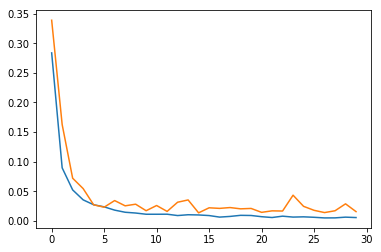

In [14]:
plt.plot(train_loss_list)
plt.plot(validation_loss_list)

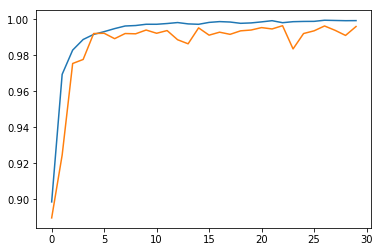

In [15]:
plt.plot(train_accuracy_list)
plt.plot(validation_accuracy_list)

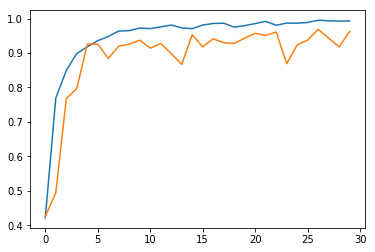

In [16]:
plt.plot(train_accuracy_per_kanji_list)
plt.plot(validation_accuracy_per_kanji_list)

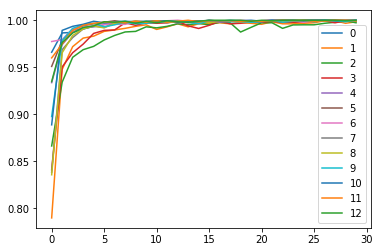

In [17]:
train_accuracy_per_radical_np_transposed = np.transpose(np.array(train_accuracy_per_radical_list), [1,0])

for i, accuracy_per_radical in enumerate(train_accuracy_per_radical_np_transposed):
    plt.plot(accuracy_per_radical, label=i)
    plt.legend()

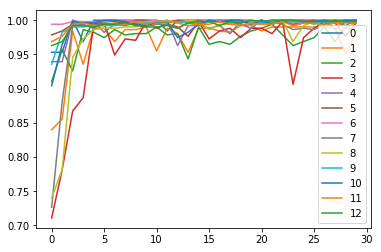

In [18]:
validation_accuracy_per_radical_np_transposed = np.transpose(np.array(validation_accuracy_per_radical_list), [1,0])

for i, accuracy_per_radical in enumerate(validation_accuracy_per_radical_np_transposed):
    plt.plot(accuracy_per_radical, label=i)
    plt.legend()

In [19]:
# make_curated_dataset.ipynbの中で作ったテストデータを読む
test_image_dir = root_dir + 'kkanji2_curated_for_test/'
test_data =  KanjiRadicalDataset(test_image_dir, os.listdir(test_image_dir), \
                                 utf16_to_radical, radical_dict, transform=tf_validation)
test_loader = DataLoader(test_data, batch_size=min(len(test_data), batchsize), shuffle=True)

# テストデータの数的に数字を出す意味があまりない気が・・・
len(test_data)

23

In [20]:
test_image, test_label = iter(test_loader).next()
pred = net(test_image.to(device))

In [21]:
pred_label = (torch.sigmoid(pred) > 0.5)
is_correct = (pred_label.cpu() == test_label.type(torch.uint8))
is_correct

tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1,

扌
少


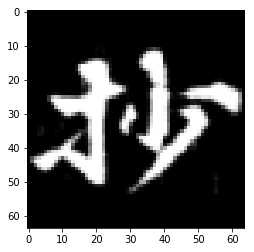

In [23]:
index = 14
plt.imshow(test_image[index].numpy().reshape(64,64), cmap='gray')
for i, value in enumerate(pred_label[index]):
    if value == 1:
        print(radical_list[i])